Found 7557 files belonging to 15 classes.
Using 6046 files for training.
Found 7557 files belonging to 15 classes.
Using 1511 files for validation.
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step
Epoch 1/20


c:\Users\maddi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_175']. Received: the structure of inputs=('*', '*')
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 604s 3s/step - accuracy: 0.3669 - loss: 2.0687 - val_accuracy: 0.8286 - val_loss: 0.5307
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 502s 3s/step - accuracy: 0.8268 - loss: 0.5695 - val_accuracy: 0.9576 - val_loss: 0.1489
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 503s 3s/step - accuracy: 0.9345 - loss: 0.2215 - val_accuracy: 0.9788 - val_loss: 0.0761
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 498s 3s/step - accuracy: 0.9601 - loss: 0.1410 - val_accuracy: 0.9821 - val_loss: 0.0516
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 509s 3s/step - accuracy: 0.9799 - loss: 0.0664 - val_accuracy: 0.9808 - val_loss: 0.0599
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 515s 3s/step - accuracy: 0.9783 - loss: 0.0714 - val_accuracy: 0.9815 - val_loss: 0.0703
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 513s 3s/step - accuracy: 0.9799 - loss: 0.0658 - val_accuracy: 0.9835 - val_loss: 0.0526
Epoch 8/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 513s 3s/step - accuracy: 0.9767 - loss: 0.0853 - val_accuracy: 0.984

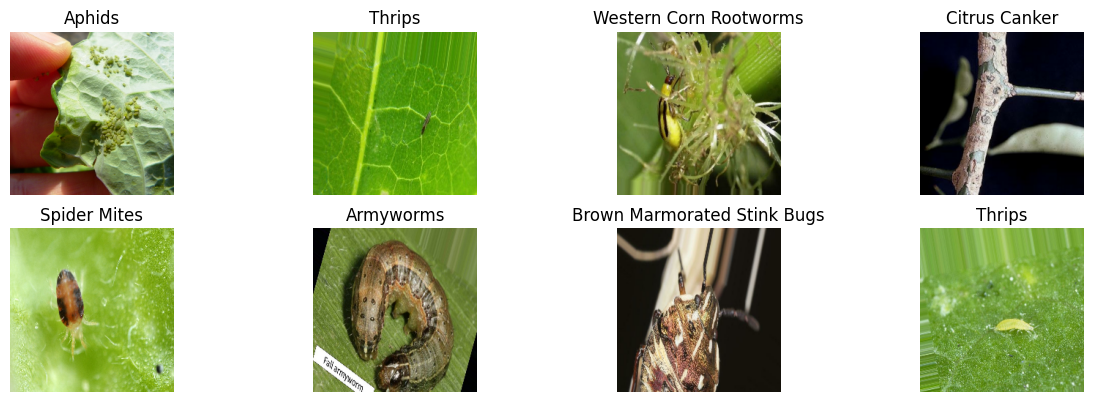

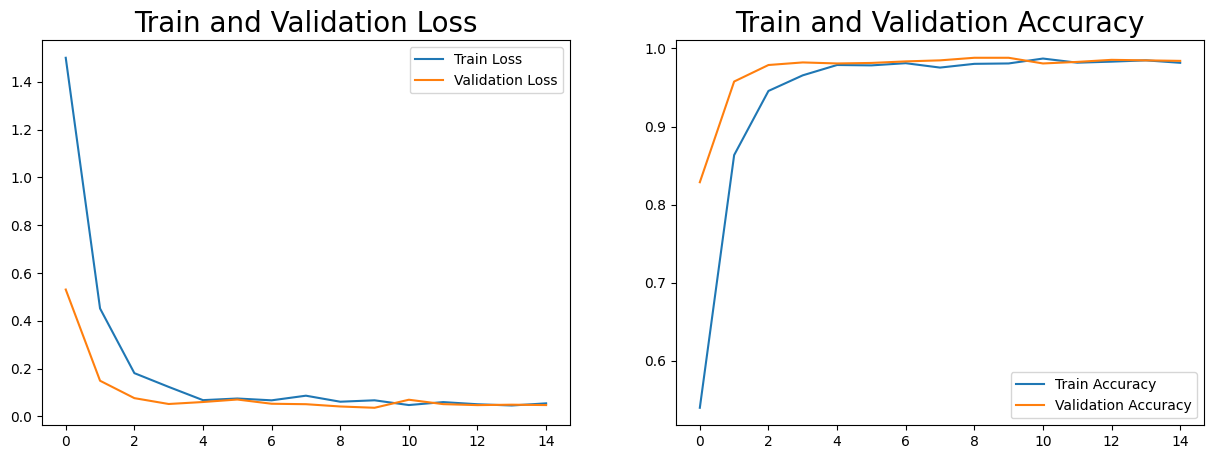

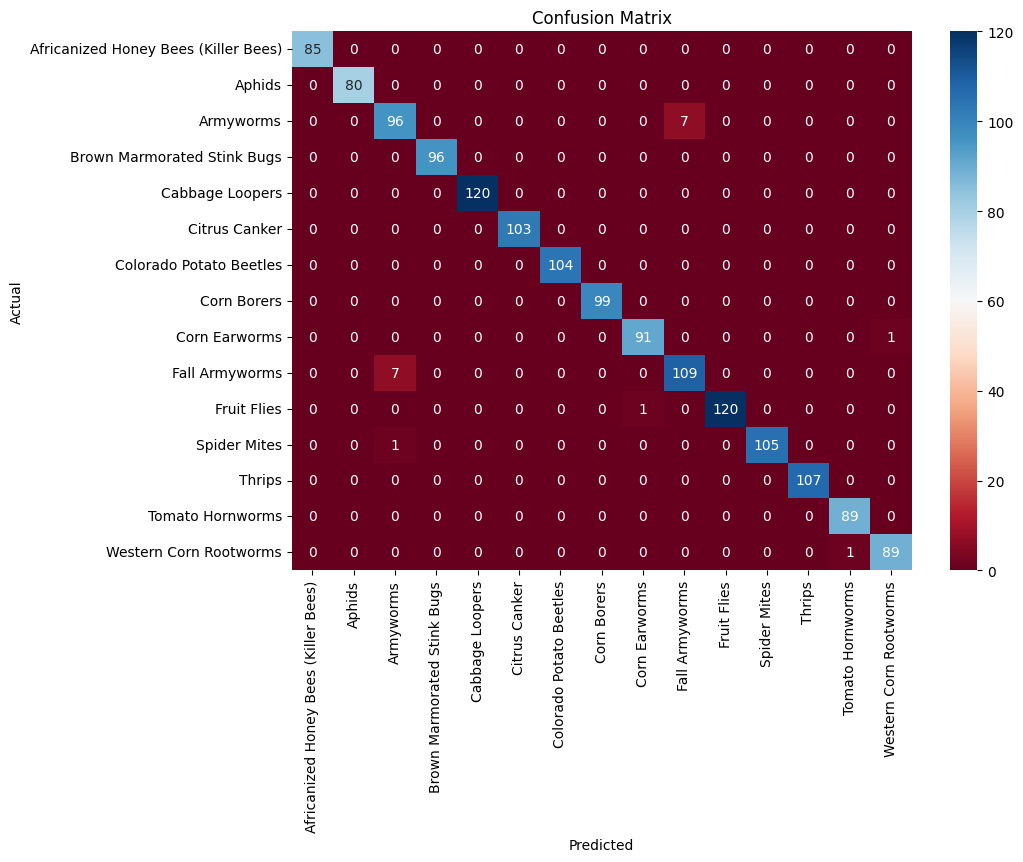

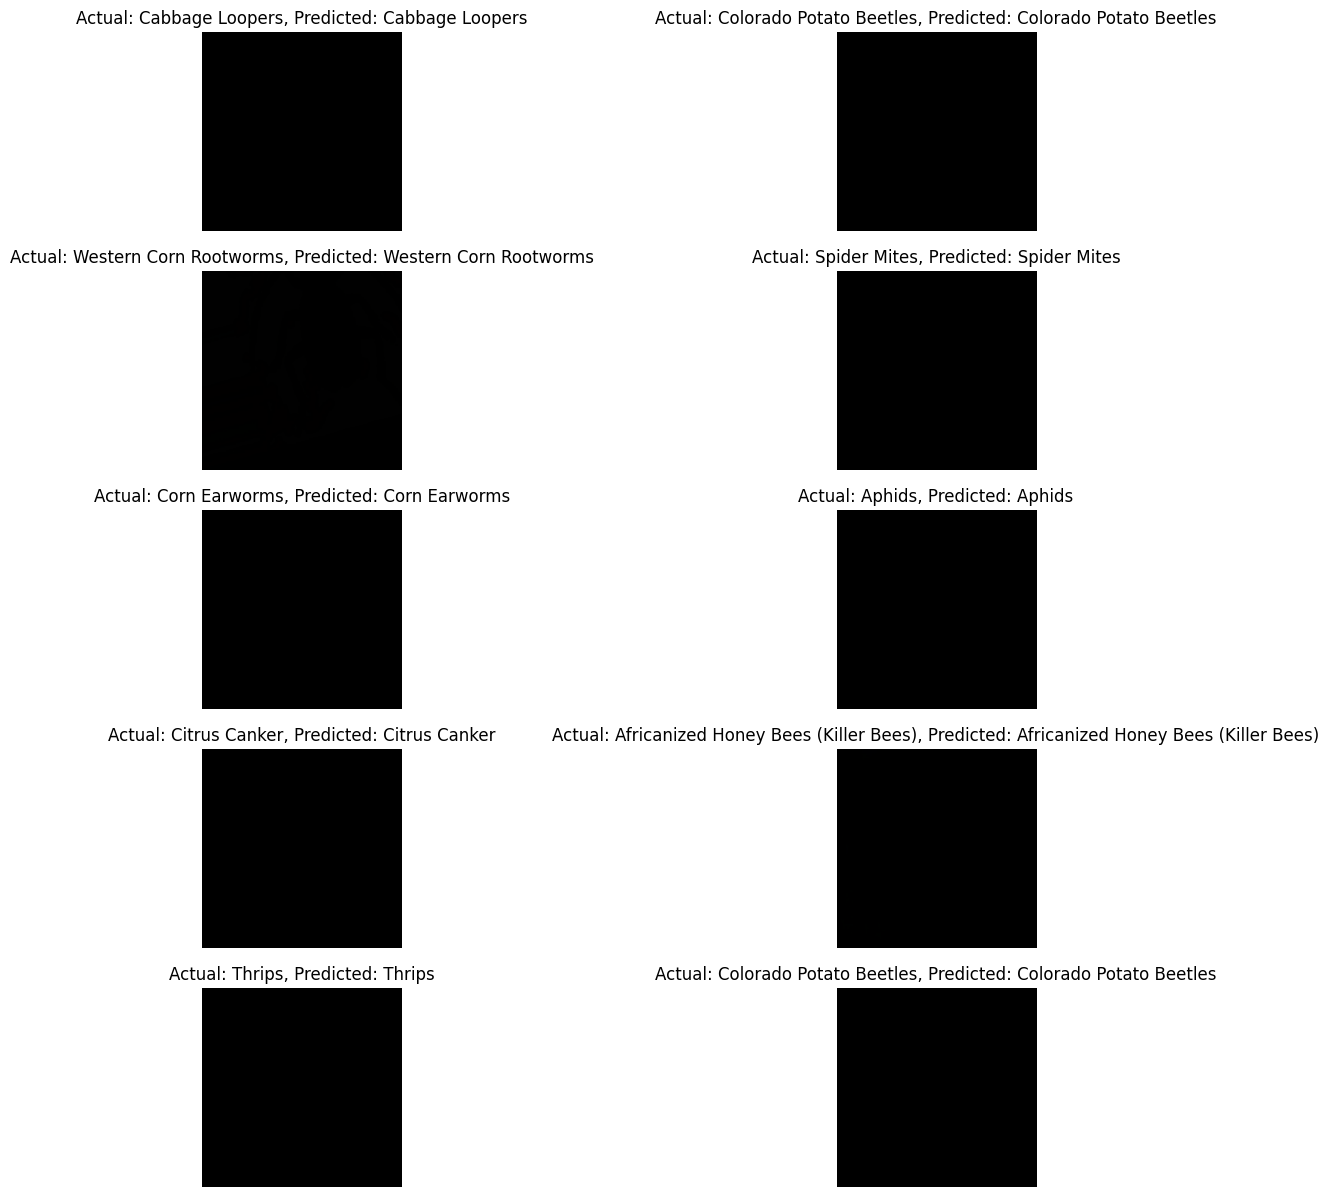

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score


image_data ='D:/m_project/farm_insect_classifier/static/uploads'
# image_data = 'C:/Users/manee/Downloads/main-codes_new/main-codes_new/farm_insect_classifier/static/uploads'

batch_size = 32
target_size = (224, 224)
validation_split = 0.2


train_raw = tf.keras.preprocessing.image_dataset_from_directory(
    image_data,
    validation_split=validation_split,
    subset="training",
    seed=100, 
    image_size=target_size,
    batch_size=batch_size,
    shuffle=True  
)

validation_raw = tf.keras.preprocessing.image_dataset_from_directory(
    image_data,
    validation_split=validation_split,
    subset="validation",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
    shuffle=True 
)


class_names = train_raw.class_names


def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label


train = train_raw.map(preprocess)
validation = validation_raw.map(preprocess)


def duplicate_inputs(image, label):
    return (image, image), label


train = train.map(duplicate_inputs)
validation = validation.map(duplicate_inputs)


plt.figure(figsize=(15, 20))
for images, labels in train_raw.take(1):  
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


mobilenetv3_base = tf.keras.applications.MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
inceptionv3_base = tf.keras.applications.InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')


mobilenetv3_base.trainable = True
inceptionv3_base.trainable = True


for layer in mobilenetv3_base.layers[:100]:
    layer.trainable = False
for layer in inceptionv3_base.layers[:100]:
    layer.trainable = False


mobilenetv3_output = mobilenetv3_base.output
mobilenetv3_output = layers.GlobalAveragePooling2D()(mobilenetv3_output)

inceptionv3_output = inceptionv3_base.output
inceptionv3_output = layers.GlobalAveragePooling2D()(inceptionv3_output)


concatenated_features = layers.Concatenate()([mobilenetv3_output, inceptionv3_output])


x = layers.Dense(128, activation='relu')(concatenated_features)
x = layers.Dropout(0.5)(x)
output = layers.Dense(len(class_names), activation='softmax')(x)


hybrid_model = keras.models.Model(inputs=[mobilenetv3_base.input, inceptionv3_base.input], outputs=output)


hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])


y_train = np.concatenate([y for x, y in train_raw], axis=0)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

hist = hybrid_model.fit(
    train,
    epochs=20,
    validation_data=validation,
    callbacks=[early_stopping],
    class_weight=class_weights
)


hist_df = pd.DataFrame(hist.history)
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(hist_df['loss'], label='Train Loss')
plt.plot(hist_df['val_loss'], label='Validation Loss')
plt.title('Train and Validation Loss', fontsize=20)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_df['accuracy'], label='Train Accuracy')
plt.plot(hist_df['val_accuracy'], label='Validation Accuracy')
plt.title('Train and Validation Accuracy', fontsize=20)
plt.legend()


X_val, y_val, y_pred = [], [], []
for (img1, img2), labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(img1.numpy()) 

predictions = hybrid_model.predict([np.array(X_val), np.array(X_val)])
y_pred = [np.argmax(i) for i in predictions]


cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='RdBu', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


import random
random_indices = random.sample(range(len(X_val)), 10)

plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_indices):
    ax = plt.subplot(5, 2, i + 1)
    plt.imshow(X_val[idx].astype("uint8"))
    actual_label = class_names[y_val[idx]]
    predicted_label = class_names[y_pred[idx]]
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis("off")
plt.show()

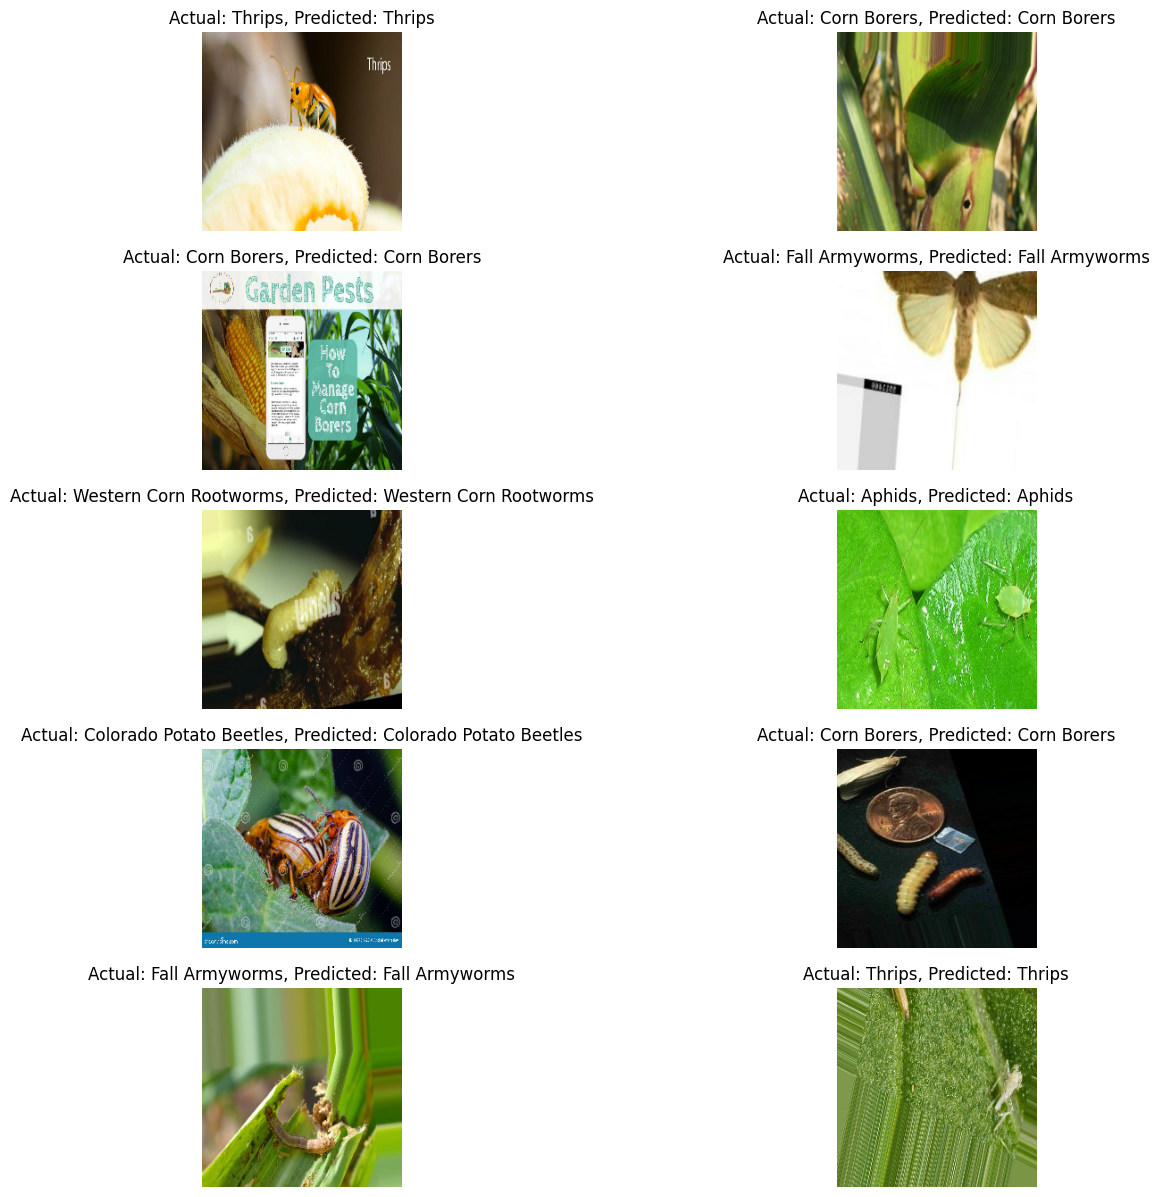

In [2]:
# Display some sample validation images with predicted and actual labels
import random
random_indices = random.sample(range(len(X_val)), 10)

plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_indices):
    ax = plt.subplot(5, 2, i + 1)
    plt.imshow((X_val[idx] * 255).astype("uint8"))  # Ensure images are in color by scaling back to 0-255
    actual_label = class_names[y_val[idx]]
    predicted_label = class_names[y_pred[idx]]
    plt.title(f"Actual: {actual_label}, Predicted: {predicted_label}")
    plt.axis("off")
plt.show()



In [4]:
hybrid_model.save('model/insect_model.keras', save_format='keras')


In [5]:
print(class_names)

['Africanized Honey Bees (Killer Bees)', 'Aphids', 'Armyworms', 'Brown Marmorated Stink Bugs', 'Cabbage Loopers', 'Citrus Canker', 'Colorado Potato Beetles', 'Corn Borers', 'Corn Earworms', 'Fall Armyworms', 'Fruit Flies', 'Spider Mites', 'Thrips', 'Tomato Hornworms', 'Western Corn Rootworms']
